<a href="https://colab.research.google.com/github/JannaBabicheva/lab02_deep_learning/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22main_notebook_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display


# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [7]:
# (re-)load layers
%run modules.ipynb

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

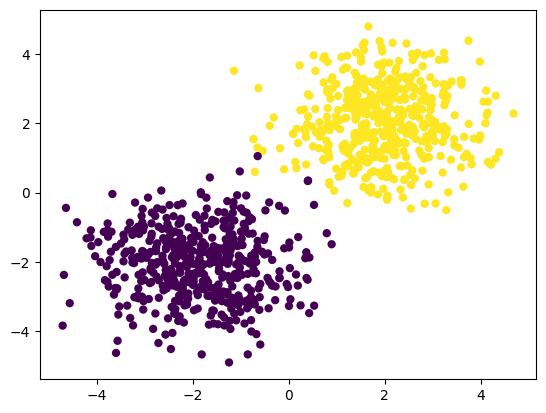

In [8]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [9]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [10]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [11]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

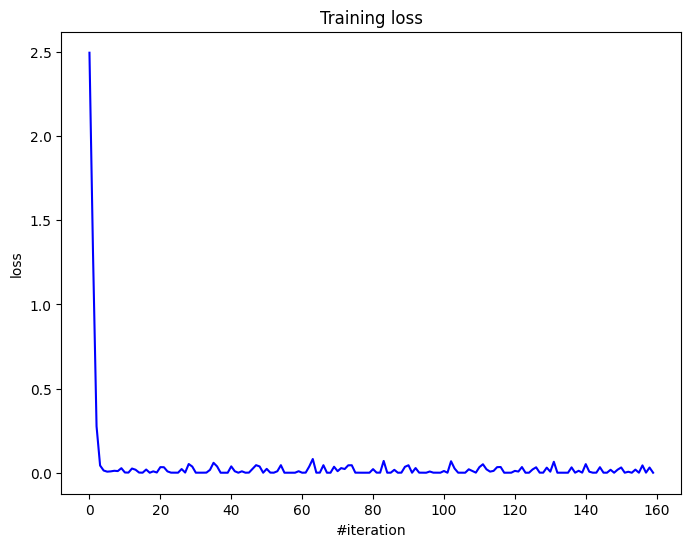

Current loss: 0.000057


In [12]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [13]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

--2024-12-12 23:58:14--  https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0s      

2024-12-12 23:58:14 (35.7 MB/s) - ‘mnist.py’ saved [2697/2697]



In [25]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

HTTPError: HTTP Error 403: Forbidden

In [14]:
import torch
from torchvision import datasets
from torchvision.transforms import transforms


In [15]:
def load_mnist_data():
    # Определяем преобразования
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Загружаем тренировочный набор
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

    # Загружаем тестовый набор
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    # Разделяем тренировочный набор на train и validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Преобразуем данные в numpy массивы
    def dataset_to_numpy(dataset):
        loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
        X, y = next(iter(loader))
        return X.numpy().reshape(len(X), -1), y.numpy()

    X_train, y_train = dataset_to_numpy(train_dataset)
    X_val, y_val = dataset_to_numpy(val_dataset)
    X_test, y_test = dataset_to_numpy(test_dataset)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
# Загружаем данные
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist_data()

print("Размеры наборов данных:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 131MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 33.2MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 86.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.17MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Размеры наборов данных:
X_train: (48000, 784)
X_val: (12000, 784)
X_test: (10000, 784)


One-hot encode the labels first.

In [17]:
# Your code goes here. ################################################
def to_one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train = to_one_hot(y_train)
y_val = to_one_hot(y_val)
y_test = to_one_hot(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [ ]:
# Your code goes here. ################################################

In [18]:
from tqdm.notebook import tqdm

In [19]:
def create_model(activation):
    net = Sequential()
    net.add(Linear(784, 256))  # входной слой
    net.add(activation())      # функция активации
    net.add(Linear(256, 128))
    net.add(activation())      # функция активации
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

In [20]:
def train_model(net, X_train, y_train, n_epochs=10, batch_size=128):
    criterion = ClassNLLCriterion()
    optimizer_config = {'learning_rate': 0.01, 'momentum': 0.9}
    optimizer_state = {}
    loss_history = []

    for epoch in tqdm(range(n_epochs), desc="Training"):
        for start_idx in range(0, len(X_train), batch_size):
            end_idx = start_idx + batch_size
            x_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            net.zeroGradParameters()

            # Прямой проход
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Обратный проход
            grad = criterion.backward(predictions, y_batch)
            net.backward(x_batch, grad)

            # Обновление весов
            sgd_momentum(net.getParameters(),
                        net.getGradParameters(),
                        optimizer_config,
                        optimizer_state)

            loss_history.append(loss)

    return loss_history

In [21]:
# Создаем и обучаем модели с разными активациями
activations = {
    'ReLU': ReLU,
    'ELU': lambda: ELU(alpha=1.0),
    'LeakyReLU': lambda: LeakyReLU(slope=0.05),
    'SoftPlus': SoftPlus
}

histories = {}
for name, activation in activations.items():
    print(f"\nTraining model with {name}")
    net = create_model(activation)
    history = train_model(net, X_train, y_train)
    histories[name] = history


Training model with ReLU


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Training model with ELU


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Training model with LeakyReLU


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Training model with SoftPlus


Training:   0%|          | 0/10 [00:00<?, ?it/s]

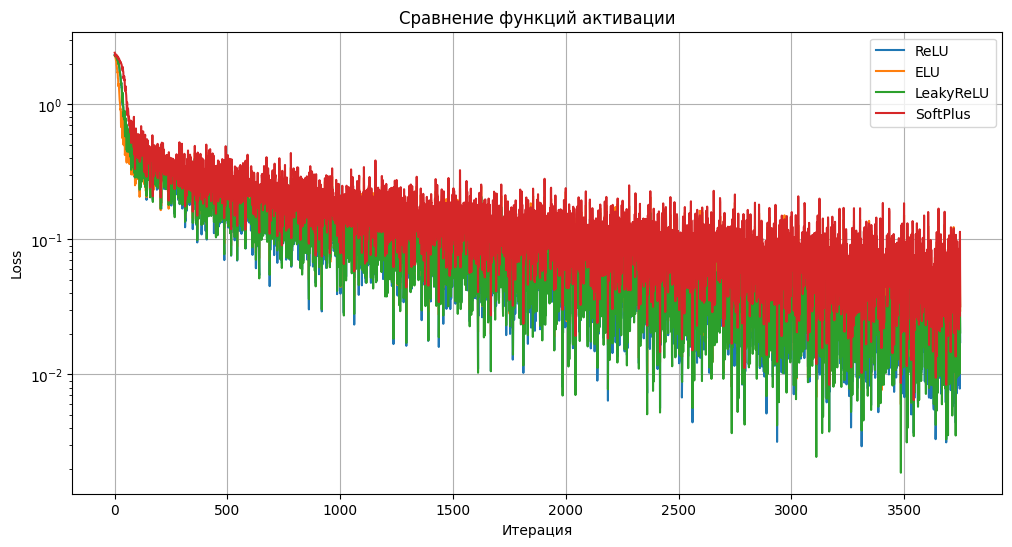

In [22]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
for name, history in histories.items():
    plt.plot(history, label=name)
plt.title('Сравнение функций активации')
plt.xlabel('Итерация')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################

In [23]:
def create_model_with_bn(activation):
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(256))
    net.add(activation())
    net.add(Linear(256, 128))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(128))
    net.add(activation())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

In [24]:
# Обучаем модели с BatchNormalization
histories_bn = {}
for name, activation in activations.items():
    print(f"\nTraining model with {name} and BatchNorm")
    net = create_model_with_bn(activation)
    history = train_model(net, X_train, y_train)
    histories_bn[name] = history


Training model with ReLU and BatchNorm


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Training model with ELU and BatchNorm


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Training model with LeakyReLU and BatchNorm


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Training model with SoftPlus and BatchNorm


Training:   0%|          | 0/10 [00:00<?, ?it/s]

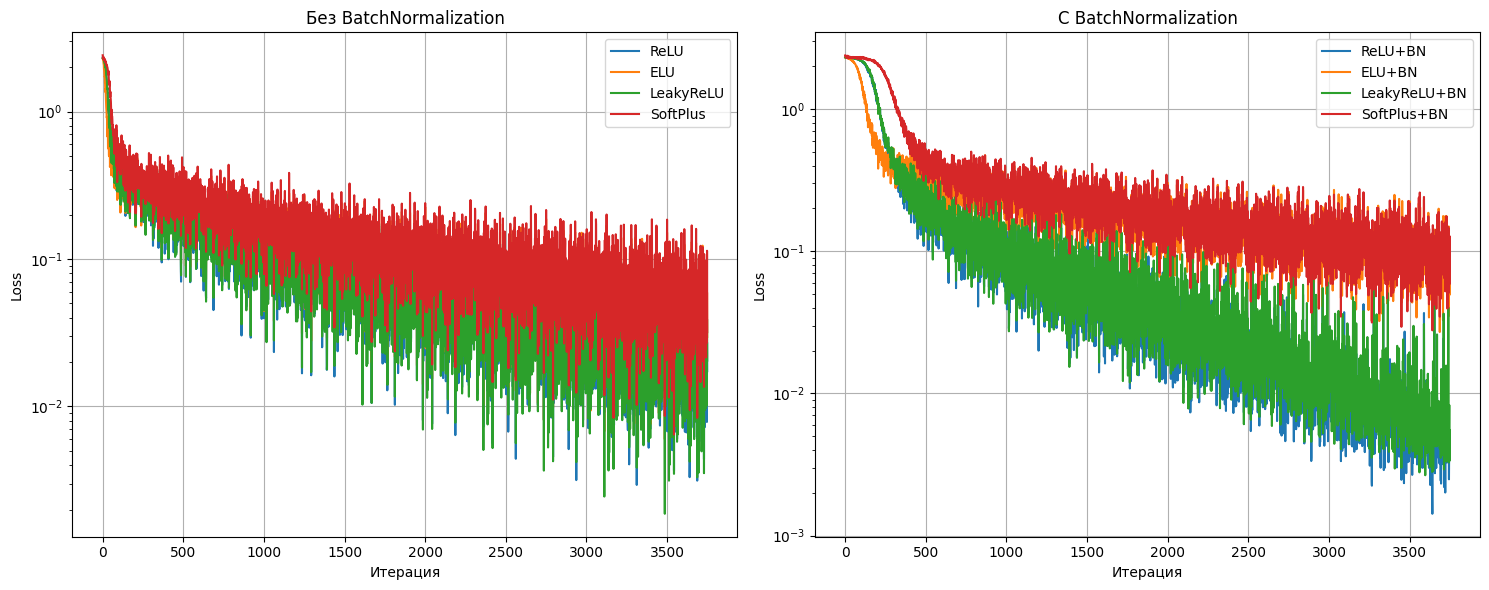

In [25]:
# Визуализация результатов
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for name, history in histories.items():
    plt.plot(history, label=name)
plt.title('Без BatchNormalization')
plt.xlabel('Итерация')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, history in histories_bn.items():
    plt.plot(history, label=f"{name}+BN")
plt.title('С BatchNormalization')
plt.xlabel('Итерация')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################

In [26]:
def create_super_model():
    net = Sequential()

    # Первый блок
    net.add(Linear(784, 512))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(512))
    net.add(ReLU())
    net.add(Dropout(p=0.2))

    # Второй блок
    net.add(Linear(512, 256))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(256))
    net.add(ReLU())
    net.add(Dropout(p=0.3))

    # Третий блок
    net.add(Linear(256, 128))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(128))
    net.add(ReLU())
    net.add(Dropout(p=0.4))

    # Выходной слой
    net.add(Linear(128, 10))
    net.add(LogSoftMax())

    return net

In [27]:
def train_super_model(net, X_train, y_train, X_val, y_val, n_epochs=30, batch_size=128):
    criterion = ClassNLLCriterion()

    # Начальные параметры оптимизатора
    optimizer_config = {
        'learning_rate': 0.01,
        'beta1': 0.9,
        'beta2': 0.999,
        'epsilon': 1e-8
    }
    optimizer_state = {}

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs), desc="Training"):
        # Включаем режим обучения
        net.train()

        # Learning rate decay
        optimizer_config['learning_rate'] = 0.01 * (0.95 ** epoch)

        # Обучение на одной эпохе
        for start_idx in range(0, len(X_train), batch_size):
            end_idx = min(start_idx + batch_size, len(X_train))
            x_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            grad = criterion.backward(predictions, y_batch)
            net.backward(x_batch, grad)

            adam_optimizer(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            train_losses.append(loss)

        # Оценка на валидационной выборке
        net.evaluate()  # переключаем в режим оценки
        val_predictions = net.forward(X_val)
        val_loss = criterion.forward(val_predictions, y_val)
        val_losses.append(val_loss)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [28]:
# Создаем и обучаем модель
super_model = create_super_model()
train_losses, val_losses = train_super_model(super_model, X_train, y_train, X_val, y_val)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.0847, Val Loss: 0.1056
Epoch 10, Train Loss: 0.0270, Val Loss: 0.0936
Epoch 15, Train Loss: 0.0018, Val Loss: 0.0934
Epoch 20, Train Loss: 0.0171, Val Loss: 0.1036
Epoch 25, Train Loss: 0.0025, Val Loss: 0.0990
Epoch 30, Train Loss: 0.0280, Val Loss: 0.1084


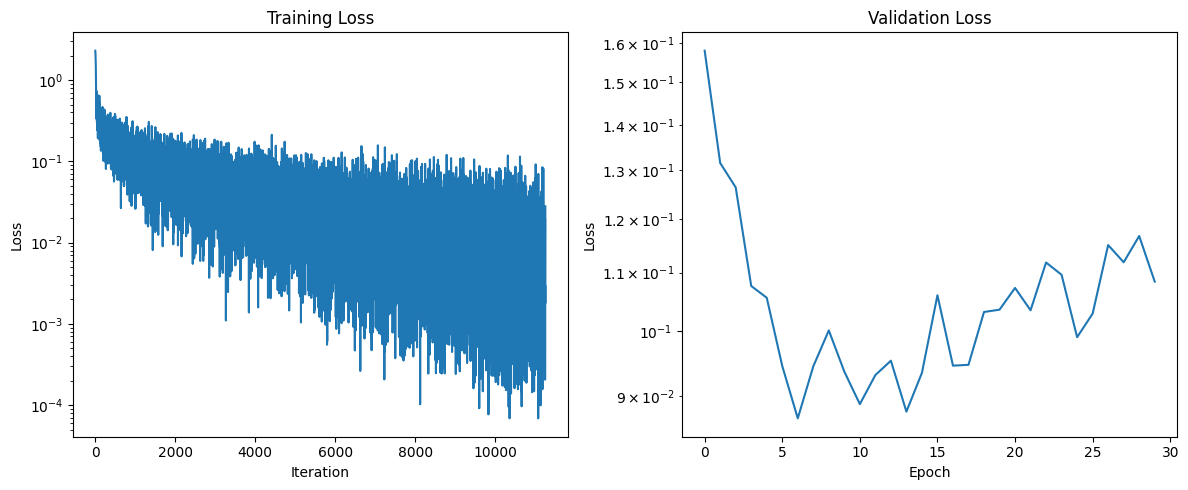

Test Accuracy: 98.19%


In [29]:
# Визуализация процесса обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

plt.tight_layout()
plt.show()

# Оценка на тестовой выборке
def calculate_accuracy(net, X, y):
    net.evaluate()
    predictions = net.forward(X)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y, axis=1)
    return np.mean(predicted_classes == true_classes) * 100

test_accuracy = calculate_accuracy(super_model, X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

In [31]:
class MNISTNet(nn.Module):
    def __init__(self, dropout_rates=[0.2, 0.3, 0.4]):
        super(MNISTNet, self).__init__()

        self.block1 = nn.Sequential(
            nn.Linear(784, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rates[0])
        )

        self.block2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rates[1])
        )

        self.block3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rates[2])
        )

        self.output = nn.Sequential(
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.output(x)

In [32]:
# Подготовка данных
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(np.argmax(y_train, axis=1))
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(np.argmax(y_val, axis=1))
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(np.argmax(y_test, axis=1))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
# Создание и обучение модели
model = MNISTNet()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    return 100 * correct / total

In [34]:
# Обучение
n_epochs = 30
train_losses = []
val_accuracies = []

for epoch in tqdm(range(n_epochs), desc="Training"):
    loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(loss)

    val_accuracy = evaluate(model, val_loader)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Training Loss: {loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/30:
Training Loss: 0.0772
Validation Accuracy: 97.85%
Epoch 10/30:
Training Loss: 0.0422
Validation Accuracy: 98.13%
Epoch 15/30:
Training Loss: 0.0244
Validation Accuracy: 98.47%
Epoch 20/30:
Training Loss: 0.0178
Validation Accuracy: 98.39%
Epoch 25/30:
Training Loss: 0.0119
Validation Accuracy: 98.45%
Epoch 30/30:
Training Loss: 0.0081
Validation Accuracy: 98.42%


In [35]:
# Финальное тестирование
test_accuracy = evaluate(model, test_loader)
print(f'\nFinal Test Accuracy: {test_accuracy:.2f}%')


Final Test Accuracy: 98.44%


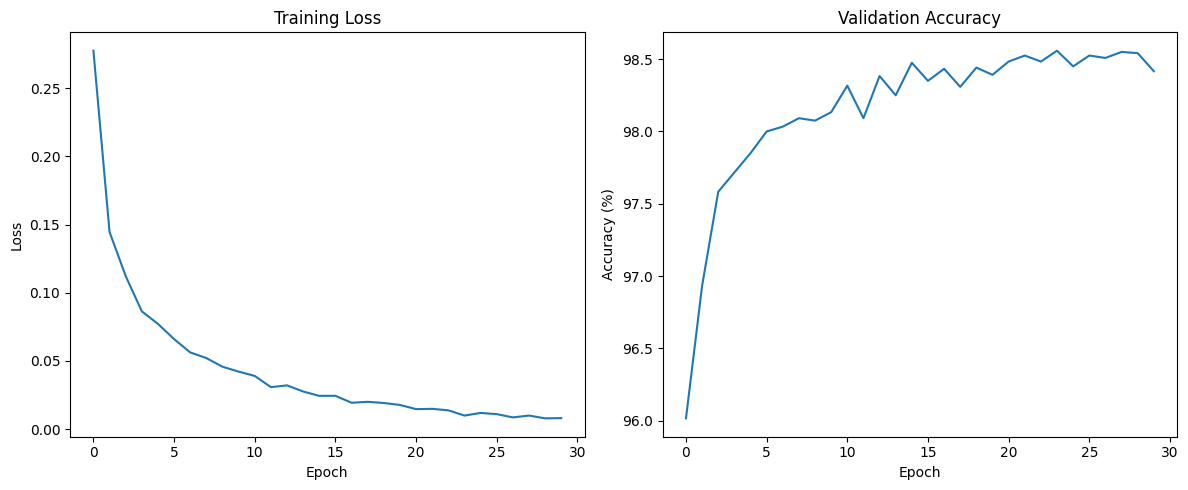

In [36]:
# Визуализация результатов
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()